<div style="border-radius:10px;
            border:#0b0265 solid;
           background-color:#DDF6A0;
           font-size:110%;
           letter-spacing:0.5px;
            text-align: center">

<center><h1 style="padding: 25px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
Speech Emotion Recognition 😁😍🤮😔😨😡</h1></center>    

</div>

<p align="center">
  <img width="1000" height="400" src="https://miro.medium.com/max/1400/1*-5u1LG7fKmIwl2pSuJeSuA.jpeg">
</p>

# <a name='Import_Libraries_and_Data'></a>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
1. Import Libraries and Data</h3></center>
</div>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Back to Table of Contents</a>

In [2]:
!pip install librosa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os
import glob
from pathlib import Path

import librosa
import librosa.display
import IPython
from IPython.display import Audio
from scipy.io.wavfile import read, write

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import sklearn

import tensorflow as tf
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model, save_model

/usr/local/lib/python3.7/dist-packages/resampy/interpn.py:114: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  _resample_loop_p(x, t_out, interp_win, interp_delta, num_table, scale, y)


In [4]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download ejlok1/toronto-emotional-speech-set-tess
! unzip /content/toronto-emotional-speech-set-tess.zip

Streaming output truncated to the last 5000 lines.
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_back_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bar_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_base_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bath_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bean_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_beg_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bite_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_boat_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bone_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_book_angry.wav  
  inflating: TESS Toronto emotional speech set data/OAF_angry/OAF_bought_angry.wav  
  inflating: TESS Toronto emotional 

In [5]:
Main_WAV_Path = Path('TESS Toronto emotional speech set data')

In [6]:
Wav_Path = list(Main_WAV_Path.glob(r'**/*.wav'))

In [7]:
Wav_Labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], Wav_Path))

In [8]:
Wav_Path_Series = pd.Series(Wav_Path, name='WAV').astype(str)
Wav_Labels_Series = pd.Series(Wav_Labels, name='EMOTION')

In [9]:
Main_Wav_Data = pd.concat([Wav_Path_Series,Wav_Labels_Series], axis=1)
Main_Wav_Data.head(5)

,WAV,EMOTION
0,TESS Toronto emotional speech set data/OAF_ang...,OAF_angry
1,TESS Toronto emotional speech set data/OAF_ang...,OAF_angry
2,TESS Toronto emotional speech set data/OAF_ang...,OAF_angry
3,TESS Toronto emotional speech set data/OAF_ang...,OAF_angry
4,TESS Toronto emotional speech set data/OAF_ang...,OAF_angry


In [10]:
Main_Wav_Data['EMOTION'].value_counts()

OAF_angry                 200
YAF_disgust               200
OAF_Sad                   200
YAF_fear                  200
YAF_happy                 200
OAF_Fear                  200
OAF_Pleasant_surprise     200
OAF_neutral               200
YAF_sad                   200
OAF_happy                 200
YAF_neutral               200
YAF_angry                 200
OAF_disgust               200
YAF_pleasant_surprised    200
Name: EMOTION, dtype: int64

In [11]:
Main_Wav_Data = Main_Wav_Data.sample(frac=1).reset_index(drop=True)
Main_Wav_Data.head(5)

,WAV,EMOTION
0,TESS Toronto emotional speech set data/OAF_dis...,OAF_disgust
1,TESS Toronto emotional speech set data/YAF_hap...,YAF_happy
2,TESS Toronto emotional speech set data/YAF_fea...,YAF_fear
3,TESS Toronto emotional speech set data/OAF_neu...,OAF_neutral
4,TESS Toronto emotional speech set data/OAF_hap...,OAF_happy


# <a name='EDA'></a>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
2. EDA</h3></center>
</div>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Back to Table of Contents</a>

Examples of Audios

In [12]:
rate, speech = read(Main_Wav_Data['WAV'][2342])
print(Main_Wav_Data['EMOTION'][2342])

Audio(speech, rate=rate, autoplay=False)

YAF_neutral


In [13]:
rate,speech = read(Main_Wav_Data['WAV'][2342])
print(Main_Wav_Data['EMOTION'][2342])
print(speech.shape)
print(speech.dtype)
print(rate)

YAF_neutral
(50823,)
int16
24414


In [14]:
rate, speech = read(Main_Wav_Data['WAV'][10])
print(Main_Wav_Data['EMOTION'][10])

Audio(speech, rate=rate, autoplay=False)

OAF_angry


In [15]:
rate,speech = read(Main_Wav_Data['WAV'][10])
print(Main_Wav_Data['EMOTION'][10])
print(speech.shape)
print(speech.dtype)
print(rate)

OAF_angry
(36848,)
int16
24414


In [16]:
rate, speech = read(Main_Wav_Data['WAV'][100])
print(Main_Wav_Data['EMOTION'][100])

Audio(speech, rate=rate, autoplay=False)

OAF_neutral


In [17]:
rate,speech = read(Main_Wav_Data['WAV'][100])
print(Main_Wav_Data['EMOTION'][100])
print(speech.shape)
print(speech.dtype)
print(rate)

OAF_neutral
(48876,)
int16
24414


Waveplot

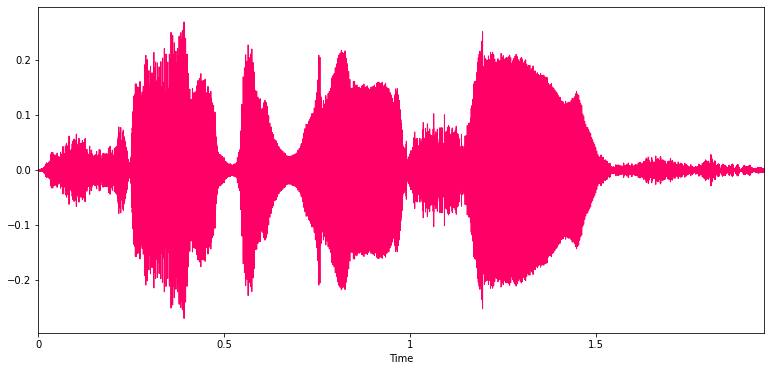

In [18]:
figure = plt.figure(figsize=(13,6))
audio_speech,rate = librosa.load(Main_Wav_Data['WAV'][120])
librosa.display.waveplot(audio_speech, sr=rate, color = '#ff0066')
Audio(audio_speech, rate=rate)

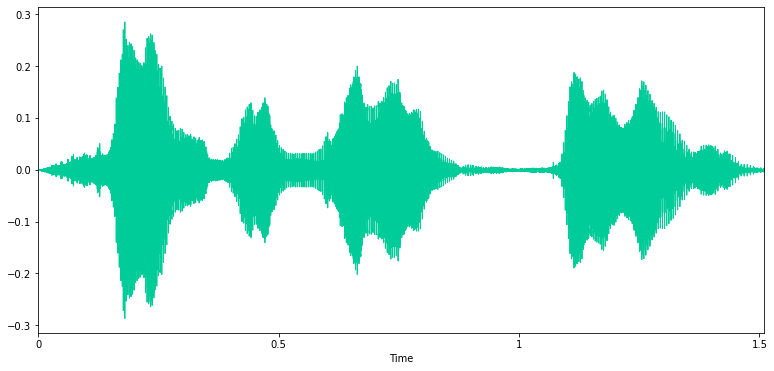

In [19]:
figure = plt.figure(figsize=(13,6))
audio_speech,rate = librosa.load(Main_Wav_Data['WAV'][10])
librosa.display.waveplot(audio_speech, sr=rate, color = '#00cc99')
Audio(audio_speech, rate=rate)

Noise:

In [20]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])
    return data

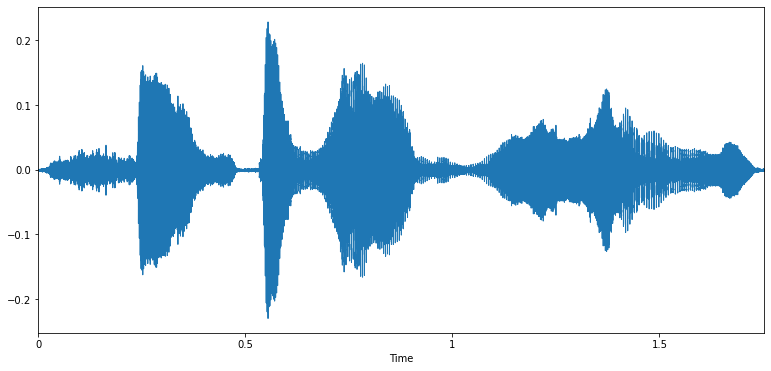

In [21]:
figure = plt.figure(figsize=(13,6))

audio_speech,sample_rate = librosa.load(Main_Wav_Data['WAV'][2000])

noise_injection = add_noise(audio_speech)

librosa.display.waveplot(noise_injection, sr=sample_rate)
Audio(noise_injection, rate=sample_rate)

Stretch:

In [22]:
def stretch_process(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

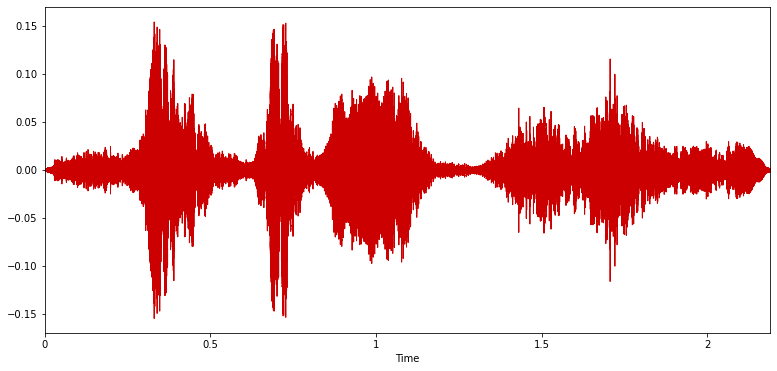

In [23]:
figure = plt.figure(figsize=(13,6))

audio_speech,sample_rate = librosa.load(Main_Wav_Data['WAV'][2000])

stretching_audio = stretch_process(audio_speech)
librosa.display.waveplot(stretching_audio, sr=sample_rate, color='#cc0000')
Audio(stretching_audio, rate=sample_rate)

Shifting:

In [24]:
def shift_process(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

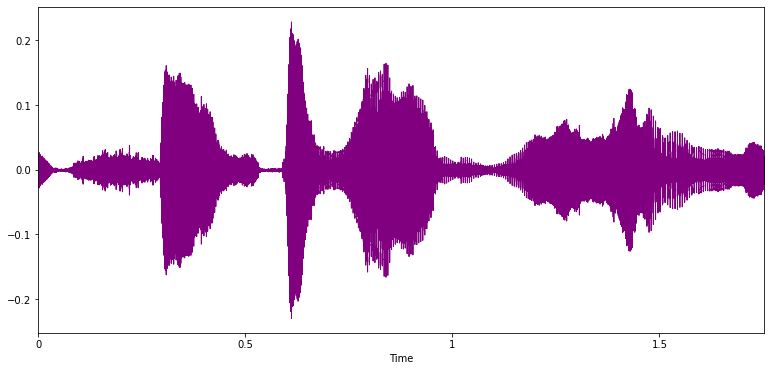

In [25]:
figure = plt.figure(figsize=(13,6))

audio_speech,sample_rate = librosa.load(Main_Wav_Data['WAV'][2000])

shifting_audio = shift_process(audio_speech)
librosa.display.waveplot(shifting_audio, sr=sample_rate, color='purple')
Audio(shifting_audio, rate=sample_rate)

Pitch:

In [26]:
def pitch_process(data,sampling_rate,pitch_factor=0.7):
    return librosa.effects.pitch_shift(data,sampling_rate, pitch_factor)

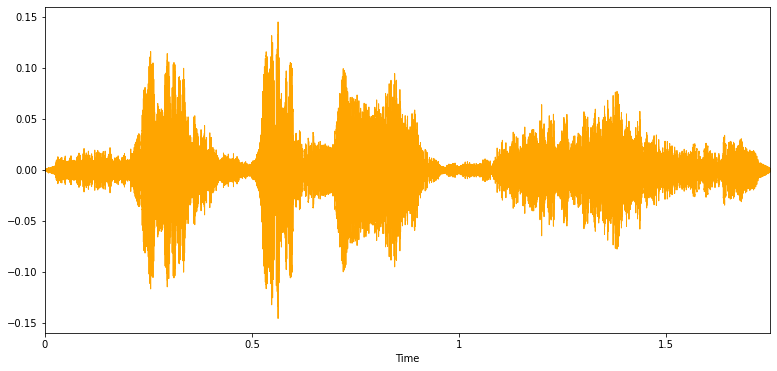

In [27]:
figure = plt.figure(figsize=(13,6))

audio_speech,sample_rate = librosa.load(Main_Wav_Data['WAV'][2000])

pitch_audio = pitch_process(audio_speech, sample_rate)
librosa.display.waveplot(pitch_audio, sr=sample_rate, color='orange')
Audio(pitch_audio, rate=sample_rate)

* Sound: sequence of vibrations in varying pressure strengths (y)
* The sample rate (sr) is the number of samples of audio carried per second, measured in Hz or kHz

In [28]:
# Importing 1 file
y, sr = librosa.load(Main_Wav_Data['WAV'][2000])

print('y:', y, '\n')
print('y shape:', np.shape(y), '\n')
print('Sample Rate (KHz):', sr, '\n')

# Verify length of the audio
print('Check Len of Audio:', np.shape(y)[0]/sr)

y: [ 0.00030614  0.00074618  0.00033639 ... -0.00029043  0.00022785
  0.        ] 

y shape: (38635,) 

Sample Rate (KHz): 22050 

Check Len of Audio: 1.752154195011338


In [29]:
# Trim leading and trailing silence from an audio signal (silence before and after the actual audio)
audio_file, _ = librosa.effects.trim(y)

# the result is an numpy ndarray
print('Audio File:', audio_file, '\n')
print('Audio File shape:', np.shape(audio_file))

Audio File: [ 0.00030614  0.00074618  0.00033639 ... -0.00029043  0.00022785
  0.        ] 

Audio File shape: (38635,)


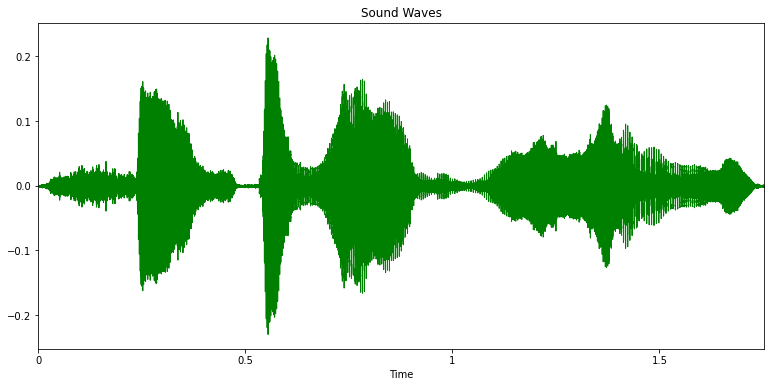

In [30]:
plt.figure(figsize = (13, 6))
librosa.display.waveplot(y = audio_file, sr = sr, color = 'green');
plt.title('Sound Waves');

Fourier Transform:

Function that gets a signal in the time domain as input, and outputs its decomposition into frequencies
Transform both the y-axis (frequency) to log scale, and the “color” axis (amplitude) to Decibels, which is approx. the log scale of amplitudes.

Shape of D object: (1025, 76)


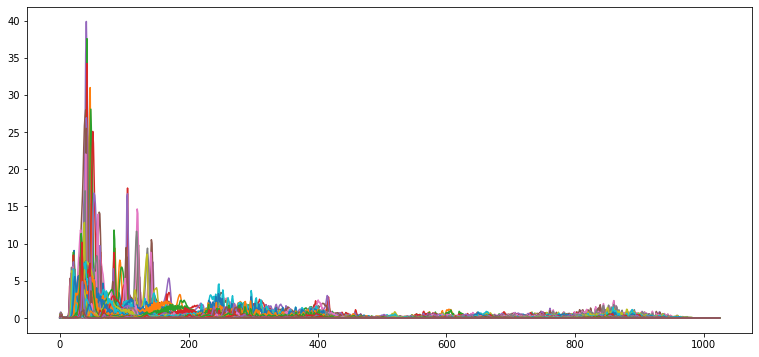

In [31]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns (looks like a good default)

# Short-time Fourier transform (STFT)
D = np.abs(librosa.stft(audio_file, n_fft = n_fft, hop_length = hop_length))

print('Shape of D object:', np.shape(D))

plt.figure(figsize = (13, 6));
plt.plot(D);

The Spectrogram:

* What is a spectrogram? A spectrogram is a visual representation of the spectrum of frequencies of a signal as it varies with time. When applied to an audio signal, spectrograms are sometimes called sonographs, voiceprints, or voicegrams (wiki).
* Here we convert the frequency axis to a logarithmic one.

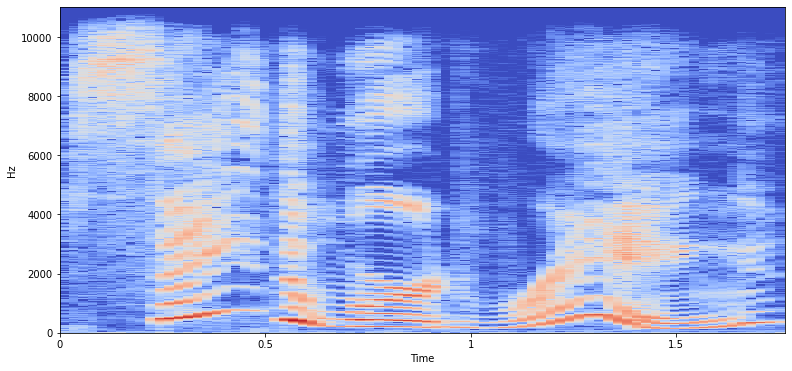

In [32]:
figure = plt.figure(figsize=(13,6))

audio_speech,rate = librosa.load(Main_Wav_Data['WAV'][2000])

stft_audio = librosa.stft(audio_speech)
Db_audio = librosa.amplitude_to_db(abs(stft_audio))
librosa.display.specshow(Db_audio, sr=rate, x_axis='time', y_axis='hz')
Audio(audio_speech, rate=rate)

Mel Spectrogram:

The Mel Scale, mathematically speaking, is the result of some non-linear transformation of the frequency scale. The Mel Spectrogram is a normal Spectrogram, but with a Mel Scale on the y axis.

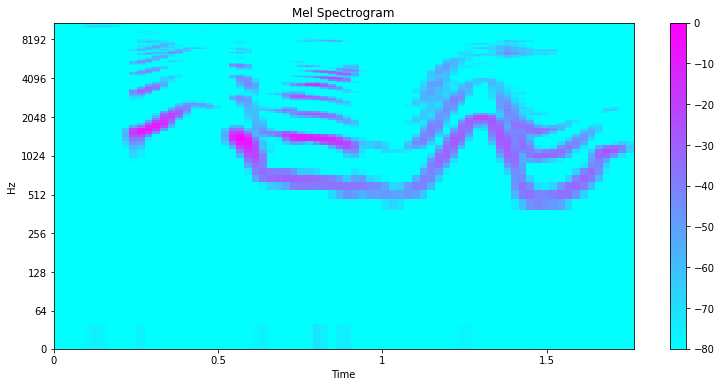

In [33]:
S = librosa.feature.melspectrogram(y, sr=sr)
S_DB = librosa.amplitude_to_db(S, ref=np.max)

plt.figure(figsize = (13, 6))
librosa.display.specshow(S_DB, sr=sr, hop_length=hop_length, x_axis = 'time', y_axis = 'log', cmap = 'cool')
plt.colorbar()
plt.title('Mel Spectrogram');

Zero Crossing Rate:

the rate at which the signal changes from positive to negative or back.

In [34]:
# Total zero_crossings in our 1 song
zero_crossings = librosa.zero_crossings(audio_file, pad=False)
print(sum(zero_crossings))

6512


Harmonics and Perceptrual:

* Harmonics are characteristichs that human years can't distinguish (represents the sound color)
* Perceptrual understanding shock wave represents the sound rhythm and emotion

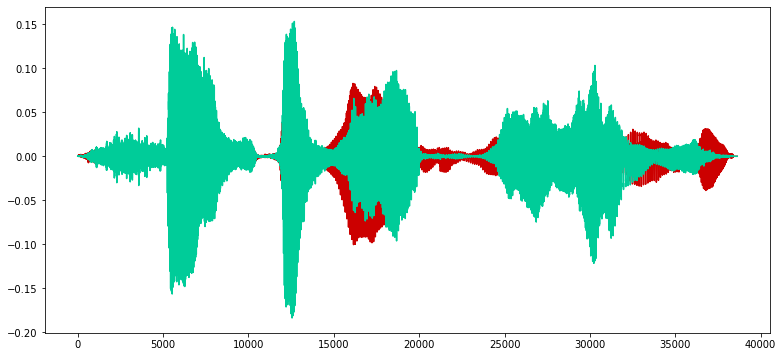

In [35]:
y_harm, y_perc = librosa.effects.hpss(audio_file)

plt.figure(figsize = (13, 6))
plt.plot(y_harm, color = '#cc0000');
plt.plot(y_perc, color = '#00cc99');

Tempo BMP (beats per minute):

Dynamic programming beat tracker.

In [36]:
tempo, _ = librosa.beat.beat_track(y, sr = sr)
tempo

129.19921875

Spectral Centroid:

indicates where the ”centre of mass” for a sound is located and is calculated as the weighted mean of the frequencies present in the sound.

In [37]:
# Calculate the Spectral Centroids
spectral_centroids = librosa.feature.spectral_centroid(audio_file, sr=sr)[0]

# Shape is a vector
print('Centroids:', spectral_centroids, '\n')
print('Shape of Spectral Centroids:', spectral_centroids.shape, '\n')

# Computing the time variable for visualization
frames = range(len(spectral_centroids))

# Converts frame counts to time (seconds)
t = librosa.frames_to_time(frames)

print('frames:', frames, '\n')
print('t:', t)

Centroids: [4940.81963865 6327.19463118 7147.81406484 7752.32331513 8004.54346528
 7990.01579971 8005.93588733 7957.94827651 7797.22797633 6310.81643739
 3279.09322006 2664.78532369 2631.25781323 2566.73179974 2627.15740144
 2819.78331455 3224.48576058 3843.56539196 4806.35431336 5406.27442188
 5444.47310102 5072.59530844 2943.16009658 2443.31665555 2150.72912428
 1725.34703627 1164.05799605 1155.83636326 1318.05302636 1481.35494691
 1701.47277336 1839.58222888 2176.9348766  2441.37694799 2541.38609607
 2422.7741886  2234.10895978 2029.68147735 1726.38485802 1407.71301498
 1181.01450703 1784.48264945 1892.81627973 1691.74903522 1869.05530676
 1571.74054844 1184.3062587   915.33896235  807.16829463  975.44375381
 1260.3584256  1521.98146897 1726.92834366 1949.94052756 2280.65694901
 2827.52662501 2980.44264109 2431.299773   2215.81878622 2378.77648939
 2274.24057491 2320.91718291 2365.44433307 2452.29295107 2500.69006128
 2382.51499047 1565.09698128 1208.08903789 1308.34128018 1303.7321

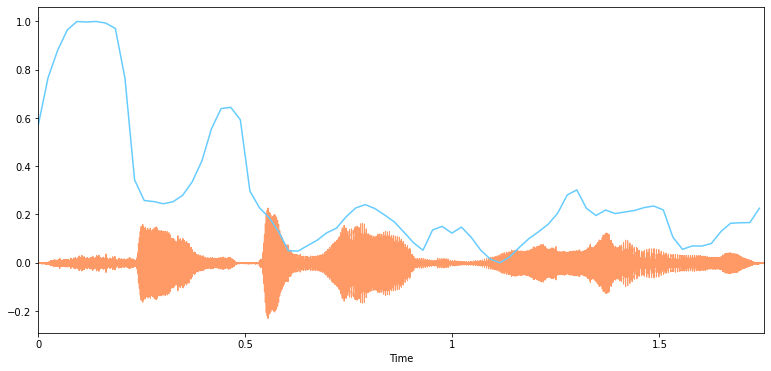

In [38]:
# Plotting the Spectral Centroid along the waveform

# Function that normalizes the Sound Data
def normalize(x, axis=0):
    return sklearn.preprocessing.minmax_scale(x, axis=axis)
    
plt.figure(figsize = (13, 6))
librosa.display.waveplot(audio_file, sr=sr, color = '#ff9966');
plt.plot(t, normalize(spectral_centroids), color='#66ccff');

Spectral Rolloff:

is a measure of the shape of the signal. It represents the frequency below which a specified percentage of the total spectral energy, e.g. 85%, lies

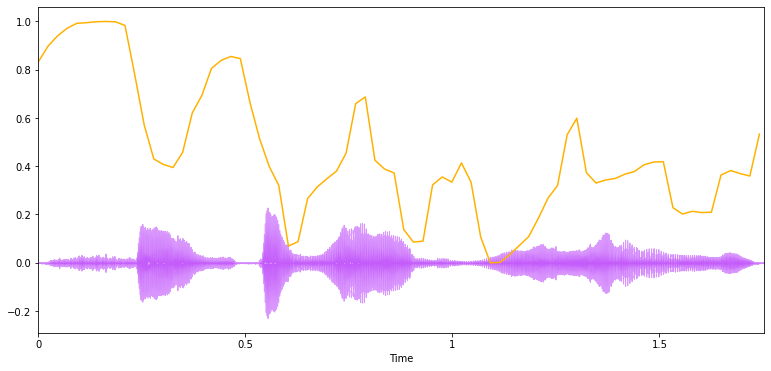

In [39]:
# Spectral RollOff Vector
spectral_rolloff = librosa.feature.spectral_rolloff(audio_file, sr=sr)[0]

# The plot
plt.figure(figsize = (13, 6))
librosa.display.waveplot(audio_file, sr=sr, alpha=0.4, color = '#A300F9');
plt.plot(t, normalize(spectral_rolloff), color='#FFB100');

Mel-Frequency Cepstral Coefficients:

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

mfccs shape: (20, 76)


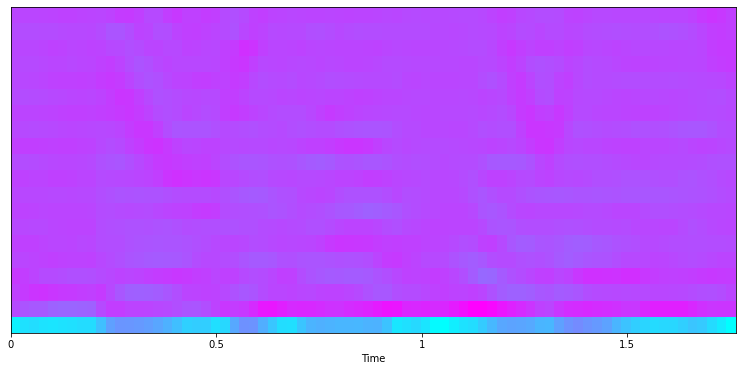

In [40]:
mfccs = librosa.feature.mfcc(audio_file, sr=sr)
print('mfccs shape:', mfccs.shape)

# Displaying  the MFCCs
plt.figure(figsize = (13, 6))
librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap = 'cool');

# <a name='Preprocessing'></a>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
3. Preprocessing</h3></center>
</div>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Back to Table of Contents</a>

In [39]:
def extract_process(data):
    
    output_result = np.array([])
    mean_zero = np.mean(librosa.feature.zero_crossing_rate(y=data).T,axis=0)
    output_result = np.hstack((output_result,mean_zero))
    
    stft_out = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft_out,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,chroma_stft))
    
    mfcc_out = np.mean(librosa.feature.mfcc(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mfcc_out))
    
    root_mean_out = np.mean(librosa.feature.rms(y=data).T,axis=0)
    output_result = np.hstack((output_result,root_mean_out))
    
    mel_spectogram = np.mean(librosa.feature.melspectrogram(y=data,sr=sample_rate).T,axis=0)
    output_result = np.hstack((output_result,mel_spectogram))
    
    return output_result

In [40]:
def export_process(path):
    
    data,sample_rate = librosa.load(path,duration=2.5,offset=0.6)
    
    output_1 = extract_process(data)
    result = np.array(output_1)
    
    noise_out = add_noise(data)
    output_2 = extract_process(noise_out)
    result = np.vstack((result,output_2))
    
    new_out = stretch_process(data)
    strectch_pitch = pitch_process(new_out,sample_rate)
    output_3 = extract_process(strectch_pitch)
    result = np.vstack((result,output_3))
    
    return result

In [42]:
X_train, y_train = [],[]

for path,emotion in zip(Main_Wav_Data.WAV, Main_Wav_Data.EMOTION):
    
    features = export_process(path)
    
    for element in features:
        X_train.append(element)
        y_train.append(emotion)

In [45]:
print(len(X_train))
print(len(y_train))
print(len(Main_Wav_Data.WAV))
print(X_train[0].shape)

8400
8400
2800
(162,)


In [47]:
New_Features_Wav = pd.DataFrame(X_train)
New_Features_Wav['EMOTIONS'] = y_train

New_Features_Wav.to_csv('New_Wav_Set.csv', index=False)
New_Features_Wav.head(5)

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,EMOTIONS
0,0.055575,0.292345,0.479627,0.334613,0.322109,0.370994,0.479266,0.933623,0.586313,0.332760,...,0.000010,0.000021,0.000015,0.000016,0.000012,0.000005,8.710197e-07,8.116926e-08,1.533833e-08,OAF_neutral
1,0.056934,0.296830,0.485121,0.340952,0.328351,0.380511,0.482851,0.934719,0.588867,0.338838,...,0.000011,0.000021,0.000015,0.000016,0.000013,0.000005,1.573915e-06,8.838117e-07,8.187312e-07,OAF_neutral
2,0.058665,0.289988,0.264271,0.457303,0.307444,0.269937,0.336408,0.464787,0.964446,0.542665,...,0.000003,0.000002,0.000003,0.000005,0.000003,0.000003,4.845274e-07,1.509497e-08,5.118255e-10,OAF_neutral
3,0.103018,0.377496,0.464786,0.470453,0.400674,0.388081,0.408613,0.528203,0.540592,0.444656,...,0.000293,0.000488,0.000507,0.000489,0.000298,0.000162,4.025916e-05,2.583791e-06,2.853317e-08,OAF_Pleasant_surprise
4,0.106507,0.401849,0.487043,0.484786,0.417820,0.424877,0.448959,0.548388,0.561508,0.470152,...,0.000318,0.000503,0.000530,0.000506,0.000315,0.000180,6.180123e-05,2.451167e-05,2.173154e-05,OAF_Pleasant_surprise


In [48]:
print(New_Features_Wav['EMOTIONS'].value_counts())

OAF_neutral               600
OAF_Pleasant_surprise     600
YAF_angry                 600
OAF_happy                 600
YAF_happy                 600
OAF_Sad                   600
YAF_pleasant_surprised    600
OAF_Fear                  600
OAF_angry                 600
YAF_sad                   600
OAF_disgust               600
YAF_disgust               600
YAF_fear                  600
YAF_neutral               600
Name: EMOTIONS, dtype: int64


In [50]:
encoder_label = OneHotEncoder()
scaler_data = StandardScaler()

In [51]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav['EMOTIONS'].values

print(X.shape)
print(Y.shape)

(8400, 162)
(8400,)


In [52]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()
print(Y.shape)

(8400, 14)


In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=0.9, random_state=42, shuffle=True)

In [54]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7560, 162)
(7560, 14)
(840, 162)
(840, 14)


In [56]:
X_train = scaler_data.fit_transform(X_train)
X_test = scaler_data.transform(X_test)

In [57]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)

In [58]:
print(X_train.shape)
print(X_test.shape)

(7560, 162, 1)
(840, 162, 1)


# <a name='Model_and_Prediction'></a>

<div style="border-radius:10px;
            background-color:#ffffff;
            border-style: solid;
            border-color: #0b0265;
            letter-spacing:0.5px;">

<center><h3 style="padding: 5px 0px; color:#0b0265; font-weight: bold; font-family: Cursive">
4. Model and Prediction</h3></center>
</div>

<a href="#toc" class="btn btn-primary btn-sm" role="button" aria-pressed="true" style="color:white" data-toggle="popover">Back to Table of Contents</a>

In [60]:
Model = tf.keras.models.Sequential()
Model.add(tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
Model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(tf.keras.layers.Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(tf.keras.layers.Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(tf.keras.layers.Dropout(0.2))

Model.add(tf.keras.layers.Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(tf.keras.layers.MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(tf.keras.layers.Flatten())
Model.add(tf.keras.layers.Dense(units=32, activation='relu'))
Model.add(tf.keras.layers.Dropout(0.3))

Model.add(tf.keras.layers.Dense(units=14, activation='softmax'))

Model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 162, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 81, 256)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 81, 256)           327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 41, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 41, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 21, 128)          0

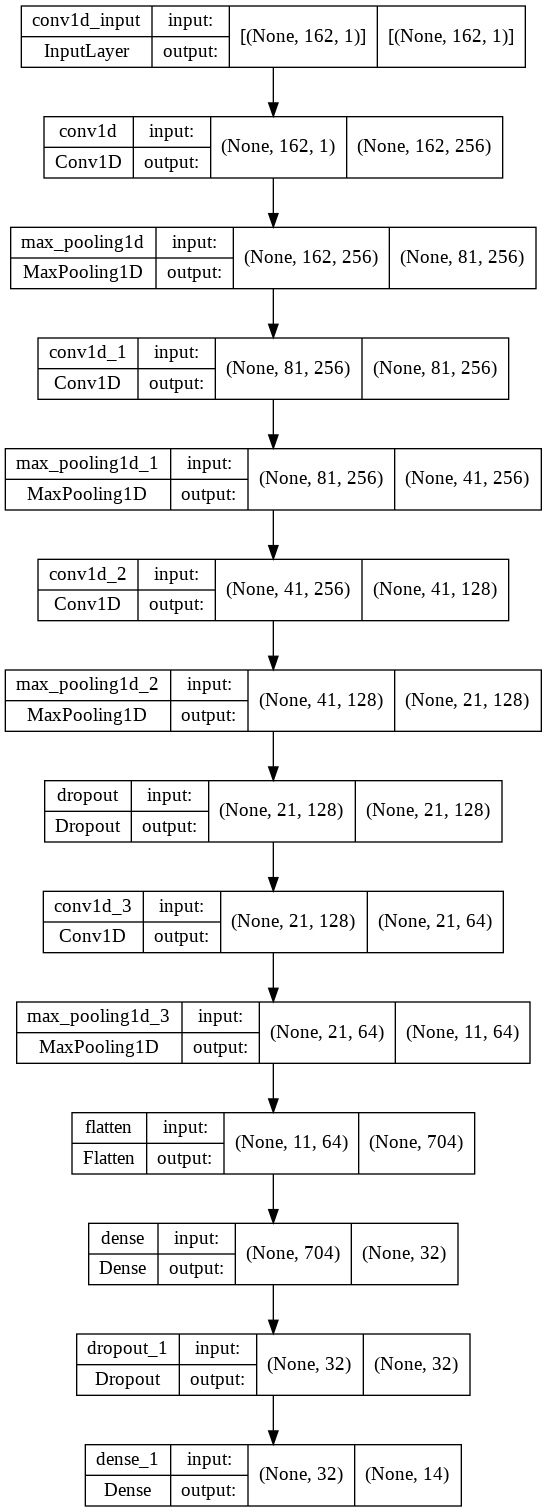

In [62]:
plot_model(Model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [66]:
EPOCHS = 50
#learning_rate = 1e-4
#decay_rate = learning_rate / EPOCHS
#opt = tf.optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)

Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

callbacks = [ModelCheckpoint('speech-emotion-recgonition.hdf5', verbose=1, save_best_only=True)]

history = Model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = (X_test, y_test))

Epoch 1/50
119/119 [==============================] - ETA: 0s - loss: 2.0021 - accuracy: 0.3382
Epoch 1: val_loss improved from inf to 0.90804, saving model to speech-emotion-recgonition.hdf5
119/119 [==============================] - 52s 431ms/step - loss: 2.0021 - accuracy: 0.3382 - val_loss: 0.9080 - val_accuracy: 0.7643
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 0.8971 - accuracy: 0.7001
Epoch 2: val_loss improved from 0.90804 to 0.34190, saving model to speech-emotion-recgonition.hdf5
119/119 [==============================] - 70s 585ms/step - loss: 0.8971 - accuracy: 0.7001 - val_loss: 0.3419 - val_accuracy: 0.9000
Epoch 3/50
119/119 [==============================] - ETA: 0s - loss: 0.5618 - accuracy: 0.8114
Epoch 3: val_loss improved from 0.34190 to 0.27352, saving model to speech-emotion-recgonition.hdf5
119/119 [==============================] - 56s 472ms/step - loss: 0.5618 - accuracy: 0.8114 - val_loss: 0.2735 - val_accuracy: 0.9119
Epoch 4/50
119

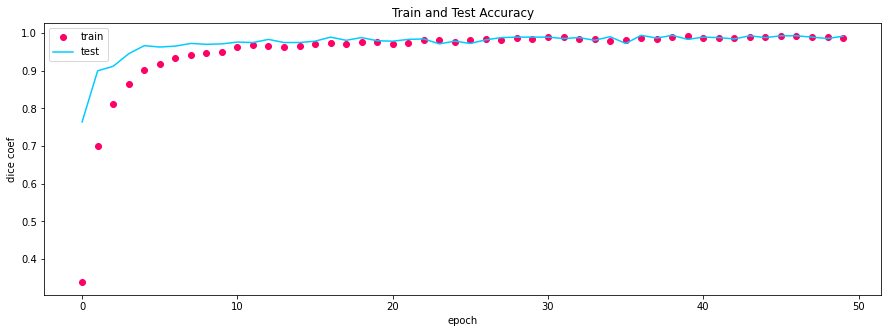

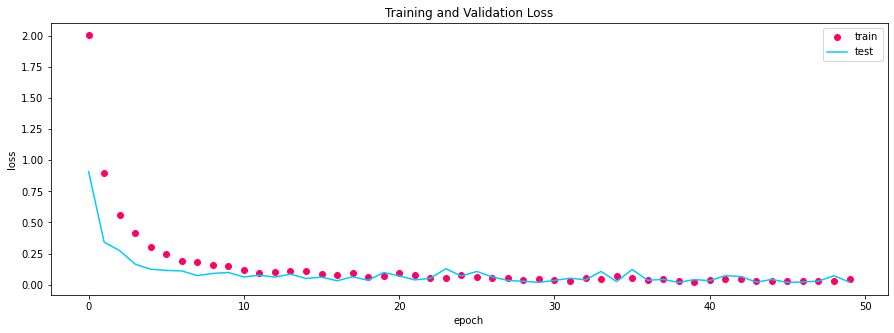

In [67]:
#-----------------------------------------------------------
# Retrieve a list of list results on train and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and test accuracy per epoch
#------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot  (epochs, acc, 'bo', color = '#ff0066')
plt.plot  (epochs, val_acc, color = '#00ccff')
plt.title ('Train and Test Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.ylabel('dice coef')
plt.xlabel('epoch');

#------------------------------------------------
# Plot training and test loss per epoch
#------------------------------------------------
plt.figure(figsize=(15,5))
plt.plot  (epochs, loss, 'bo', color = '#ff0066')
plt.plot  (epochs, val_loss, color = '#00ccff')
plt.legend(['train', 'test'], loc='upper right')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title ('Training and Validation Loss');

In [70]:
model = load_model('speech-emotion-recgonition.hdf5')

In [72]:
results = model.evaluate(X_test, y_test)

27/27 [==============================] - 2s 70ms/step - loss: 0.0184 - accuracy: 0.9929


In [73]:
print('Test loss: ', results[0])
print('Test Acuuracy: ', results[1])

Test loss:  0.018359793350100517
Test Acuuracy:  0.9928571581840515


In [76]:
prediction_test = Model.predict(X_test)
y_prediction = encoder_label.inverse_transform(prediction_test)

y_test = encoder_label.inverse_transform(y_test)

In [75]:
print(prediction_test[0:10])

[[1.2539381e-35 2.6577417e-25 1.0000000e+00 8.2832591e-27 7.3499556e-14
  7.7953851e-22 8.5821120e-17 0.0000000e+00 1.0052549e-23 6.5280599e-38
  0.0000000e+00 1.8144091e-31 7.1360247e-24 1.7140523e-15]
 [2.3596723e-33 1.7425503e-18 2.3295285e-28 2.4711690e-27 3.2881669e-23
  5.1089242e-23 6.4766343e-25 7.9290117e-18 1.7867358e-16 1.3654086e-17
  2.5968544e-28 1.5442032e-25 1.0000000e+00 6.4055432e-20]
 [1.0000000e+00 8.0895154e-22 3.4732483e-38 2.5107539e-20 3.3402157e-23
  5.3391074e-26 1.0854162e-28 4.1783998e-29 3.5626304e-32 5.0885492e-27
  1.1747909e-24 1.0154011e-26 8.8076060e-33 1.1067026e-34]
 [1.8798333e-16 2.9010328e-16 2.3319381e-13 1.2988915e-18 7.1985068e-14
  9.7448682e-23 1.0000000e+00 9.0837906e-26 3.6552545e-22 3.0899621e-22
  1.0979684e-27 1.6812562e-14 9.6981158e-13 2.8822607e-22]
 [2.3574526e-16 1.0000000e+00 1.7059810e-25 2.5045686e-17 2.2699506e-10
  1.8099232e-08 6.8503353e-22 2.1773176e-18 2.2160013e-14 7.4349589e-19
  2.6823290e-25 1.4266034e-24 6.5437879e-13 

In [77]:
print(y_prediction[0:10])

[['OAF_Sad']
 ['YAF_pleasant_surprised']
 ['OAF_Fear']
 ['OAF_neutral']
 ['OAF_Pleasant_surprise']
 ['OAF_happy']
 ['YAF_neutral']
 ['YAF_neutral']
 ['OAF_Fear']
 ['OAF_Pleasant_surprise']]


In [78]:
print(y_test[0:10])

[['OAF_Sad']
 ['YAF_pleasant_surprised']
 ['OAF_Fear']
 ['OAF_neutral']
 ['OAF_Pleasant_surprise']
 ['OAF_happy']
 ['YAF_neutral']
 ['YAF_neutral']
 ['OAF_Fear']
 ['OAF_Pleasant_surprise']]


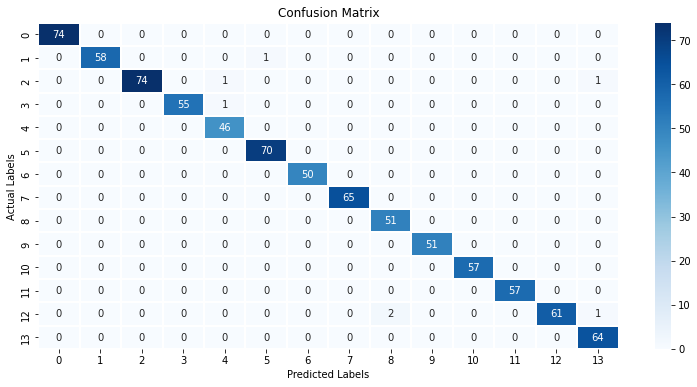

In [80]:
conf_matrix = confusion_matrix(y_test, y_prediction)

plt.figure(figsize=(13,6))
sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels');

In [81]:
print(classification_report(y_test, y_prediction))

                        precision    recall  f1-score   support

              OAF_Fear       1.00      1.00      1.00        74
 OAF_Pleasant_surprise       1.00      0.98      0.99        59
               OAF_Sad       1.00      0.97      0.99        76
             OAF_angry       1.00      0.98      0.99        56
           OAF_disgust       0.96      1.00      0.98        46
             OAF_happy       0.99      1.00      0.99        70
           OAF_neutral       1.00      1.00      1.00        50
             YAF_angry       1.00      1.00      1.00        65
           YAF_disgust       0.96      1.00      0.98        51
              YAF_fear       1.00      1.00      1.00        51
             YAF_happy       1.00      1.00      1.00        57
           YAF_neutral       1.00      1.00      1.00        57
YAF_pleasant_surprised       1.00      0.95      0.98        64
               YAF_sad       0.97      1.00      0.98        64

              accuracy                